# Cluster of OD pairs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from collections import defaultdict
pd.set_option('display.max_columns', None)

## 1. Import and format the itineraries

In [2]:
# import the itineraries from MultiModX
itineraries=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\v=0.13\processed_cs10.pp00.so00_c1\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")

In [3]:
itineraries.sample(5)

,origin,destination,journey_type,cluster_id,alternative_id,options_in_cluster,total_travel_time,total_cost,total_emissions,total_waiting_time,nservices
3291,ES422,ES421,rail,0,ES422_ES421_0,"[0, 1, 2, 3, 4, 5, 6, 7]",203.25,12.82,4.02,0.0,1.0
5928,ES612,ES620,air,0,ES612_ES620_0,"[0, 1]",492.50,257.71,99.18,25.5,2.0
5118,ES523,ES425,rail,19,ES523_ES425_19,"[19, 26]",302.00,27.22,7.91,0.0,1.0
1284,ES213,ES422,air,0,ES213_ES422_0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",371.91,117.78,43.74,0.0,1.0
2379,ES412,ES522,multimodal,1,ES412_ES522_1,"[1, 3]",666.00,143.44,74.80,113.0,2.0


In [4]:
itineraries.shape[0]

7500

The dataframe contains information about:
- the type of itinerary (rail, air or multimodal)
- the total travel time of each itinerary
- the total cost of each itinerary
- the total emissions of each itinerary
- the total waiting time of each itinerary
- the number of services (this is cap to 2 because we are limiting ourselves to one connection)

There are 57 possible origin and destinations and 7500 itineraries. To cluster the OD pair by their itineraries I decided to look at:
- num_air=the number of itineraries done by plane
- num_train=the number of itineraries done by train
- num_multimodal=the number of multimodal itineraries
- num_itineraries=the total number of itineraries between that OD pair
- avg_travel_time=the average travel time for that OD pair
- max_travel_time=the maximum travel time for that OD pair
- min_travel_time=the minimum travel time for that OD pair
- avg_cost=the average cost for that OD pair
- max_cost=the maximum cost for that OD pair
- min_cost=the minimum cost for that OD pair
- avg_emissions=the average emissions for that OD pair
- max_emissions=the maximum emissions for that OD pair
- min_emissions=the minimum emissions for that OD pair
- avg_waiting_time=the waiting time for that OD pair
- max_waiting_time=the maximum waiting time for that OD pair
- min_waiting_time=the minimum waiting time for that OD pair
- avg_services= the number of services on average for each itinerary of that OD pair (note that the max per itinerary is 2 and the minimum is 1)

In [5]:
def format_itineraries(itineraries):
    #preformat
    itineraries_for_cluster=itineraries.drop(["cluster_id","alternative_id","options_in_cluster"],axis=1)
    itineraries_for_cluster["itinerary_num"]=itineraries_for_cluster.groupby(["origin","destination"]).cumcount()+1
    
    #pivot
    itineraries_for_cluster=itineraries_for_cluster.pivot(index=["origin","destination"],columns="itinerary_num",values=["journey_type","total_travel_time","total_cost","total_emissions","total_waiting_time","nservices"])
    
    #re-assign column names
    itineraries_for_cluster.columns=[f"{col[0]}_{col[1]}" for col in itineraries_for_cluster.columns]
    itineraries_for_cluster=itineraries_for_cluster.reset_index()

    #extract the characteristics for the clustering

    #journey type characteristics
    journey_cols=[col for col in itineraries_for_cluster.columns if col.startswith("journey_type")]
    itineraries_for_cluster["num_air"]=(itineraries_for_cluster[journey_cols]=="air").sum(axis=1)
    itineraries_for_cluster["num_multimodal"]=(itineraries_for_cluster[journey_cols]=="multimodal").sum(axis=1)
    itineraries_for_cluster["num_rail"]=(itineraries_for_cluster[journey_cols]=="rail").sum(axis=1)
    itineraries_for_cluster["num_itineraries"]=itineraries_for_cluster["num_multimodal"]+itineraries_for_cluster["num_rail"]+itineraries_for_cluster["num_air"]
    itineraries_for_cluster=itineraries_for_cluster.drop(journey_cols,axis=1)

    #travel time characteristics
    travel_time_cols=[col for col in itineraries_for_cluster.columns if col.startswith("total_travel_time")]
    itineraries_for_cluster["avg_travel_time"]=(itineraries_for_cluster[travel_time_cols]).mean(axis=1)
    itineraries_for_cluster["max_travel_time"]=(itineraries_for_cluster[travel_time_cols]).max(axis=1)
    itineraries_for_cluster["min_travel_time"]=(itineraries_for_cluster[travel_time_cols]).min(axis=1)
    itineraries_for_cluster=itineraries_for_cluster.drop(travel_time_cols,axis=1)

    #cost characteristics
    cost_cols=[col for col in itineraries_for_cluster.columns if col.startswith("total_cost")]
    itineraries_for_cluster["avg_cost"]=(itineraries_for_cluster[cost_cols]).mean(axis=1)
    itineraries_for_cluster["max_cost"]=(itineraries_for_cluster[cost_cols]).max(axis=1)
    itineraries_for_cluster["min_cost"]=(itineraries_for_cluster[cost_cols]).min(axis=1)
    itineraries_for_cluster=itineraries_for_cluster.drop(cost_cols,axis=1)

    #emissions characteristics
    emissions_cols=[col for col in itineraries_for_cluster.columns if col.startswith("total_emissions")]
    itineraries_for_cluster["avg_emissions"]=(itineraries_for_cluster[emissions_cols]).mean(axis=1)
    itineraries_for_cluster["max_emissions"]=(itineraries_for_cluster[emissions_cols]).max(axis=1)
    itineraries_for_cluster["min_emissions"]=(itineraries_for_cluster[emissions_cols]).min(axis=1)
    itineraries_for_cluster=itineraries_for_cluster.drop(emissions_cols,axis=1)

    #waiting time characteristics
    waiting_time_cols=[col for col in itineraries_for_cluster.columns if col.startswith("total_waiting_time")]
    itineraries_for_cluster["avg_waiting_time"]=(itineraries_for_cluster[waiting_time_cols]).mean(axis=1)
    itineraries_for_cluster["max_waiting_time"]=(itineraries_for_cluster[waiting_time_cols]).max(axis=1)
    itineraries_for_cluster["min_waiting_time"]=(itineraries_for_cluster[waiting_time_cols]).min(axis=1)
    itineraries_for_cluster=itineraries_for_cluster.drop(waiting_time_cols,axis=1)

    #service characteristics
    services_cols=[col for col in itineraries_for_cluster.columns if col.startswith("nservices")]
    itineraries_for_cluster["avg_nservice"]=(itineraries_for_cluster[services_cols]).mean(axis=1)
    itineraries_for_cluster=itineraries_for_cluster.drop(services_cols,axis=1)

    return itineraries_for_cluster


In [6]:
itineraries_for_cluster=format_itineraries(itineraries)

In [7]:
itineraries_for_cluster.columns

Index(['origin', 'destination', 'num_air', 'num_multimodal', 'num_rail',
       'num_itineraries', 'avg_travel_time', 'max_travel_time',
       'min_travel_time', 'avg_cost', 'max_cost', 'min_cost', 'avg_emissions',
       'max_emissions', 'min_emissions', 'avg_waiting_time',
       'max_waiting_time', 'min_waiting_time', 'avg_nservice'],
      dtype='object')

In [8]:
itineraries_for_cluster.sample(5)

,origin,destination,num_air,num_multimodal,num_rail,num_itineraries,avg_travel_time,max_travel_time,min_travel_time,avg_cost,max_cost,min_cost,avg_emissions,max_emissions,min_emissions,avg_waiting_time,max_waiting_time,min_waiting_time,avg_nservice
1783,ES616,ES422,2,0,1,3,461.94,560.0,274.82,92.51,131.11,15.31,36.04,64.22,4.8,0.0,0.0,0.0,1.0
282,ES212,ES230,3,1,2,6,472.633333,650.0,242.8,147.788333,250.49,9.71,63.313333,109.18,3.04,79.666667,193.0,0.0,1.666667
755,ES415,ES243,0,2,1,3,544.713333,696.0,335.0,110.64,159.94,41.34,40.856667,59.74,12.95,23.476667,30.0,16.43,2.0
1379,ES522,ES532,1,1,0,2,398.475,478.73,318.22,115.26,118.58,111.94,39.59,40.38,38.8,9.82,19.64,0.0,1.5
1678,ES613,ES424,1,0,1,2,328.315,372.71,283.92,80.43,128.8,32.06,35.45,60.86,10.04,11.085,22.17,0.0,1.5


In [9]:
itineraries_corr=itineraries_for_cluster.drop(["origin","destination"],axis=1)

In [10]:
corr=itineraries_corr.corr()

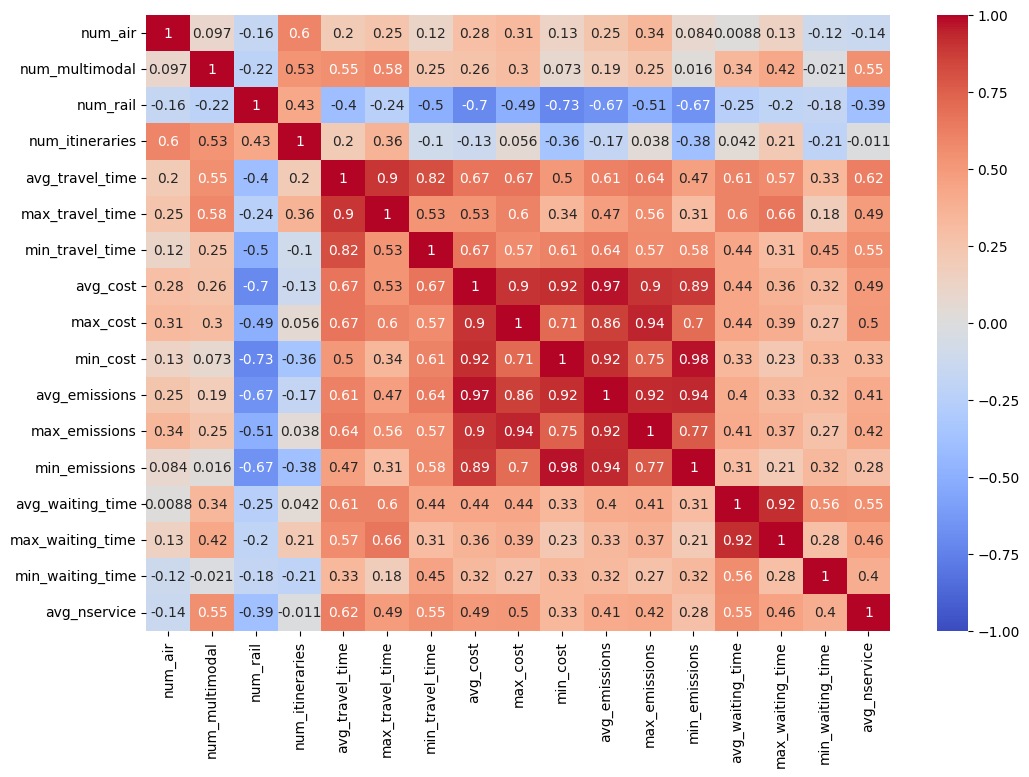

In [11]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

I will remove the max, min of all the quantities since they seem to be very correlated with the average and for me averages are important in the clustering

In [12]:
itineraries_corr=itineraries_corr.drop(["max_travel_time","max_cost","max_emissions","min_travel_time","min_cost","min_emissions"],axis=1)

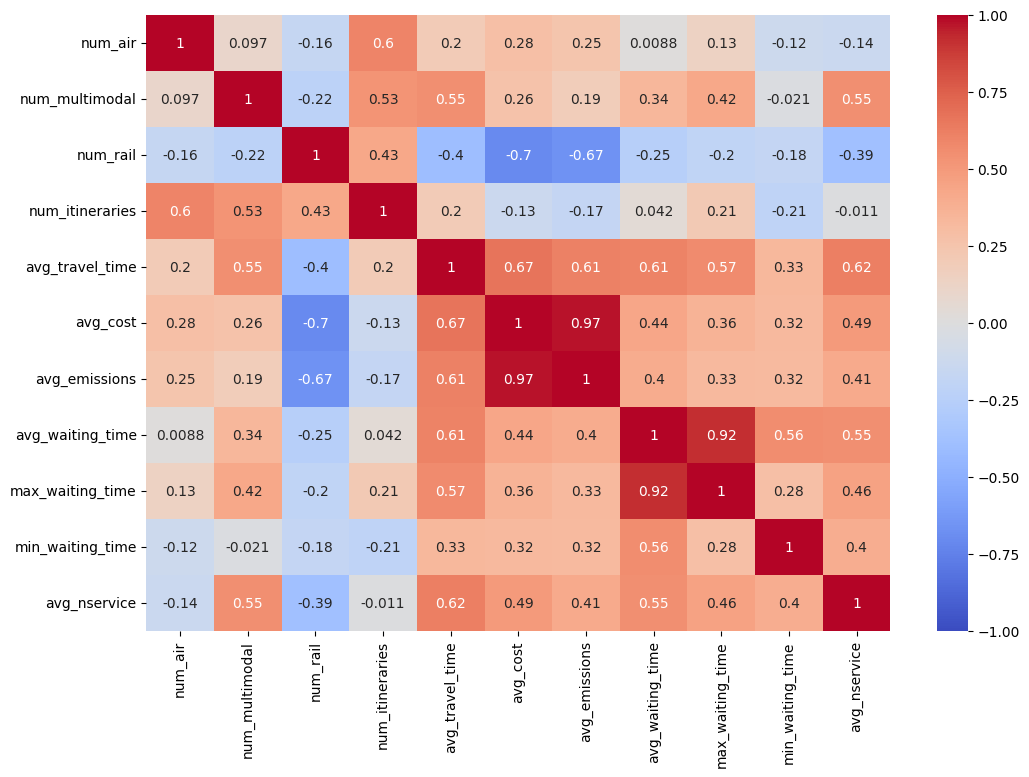

In [13]:
corr=itineraries_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()

# 2 cluster removing max, min and avg services

I will also remove n services since it is caped by the experiment

In [14]:
itineraries_for_cluster=itineraries_for_cluster.set_index(["origin","destination"])

In [15]:
itineraries_for_cluster=itineraries_for_cluster.drop(["max_travel_time","max_cost","max_emissions","min_travel_time","min_cost","min_emissions","avg_nservice","min_waiting_time","max_waiting_time"],axis=1)

In [16]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(itineraries_for_cluster)

In [17]:
def wcss(X_scaled):    
    wcss = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_scaled)  # Use your scaled data
        wcss.append(kmeans.inertia_)  # WCSS for each k

    plt.plot(range(1, 15), wcss, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("WCSS")
    plt.title("Elbow Method")
    plt.show()

c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^

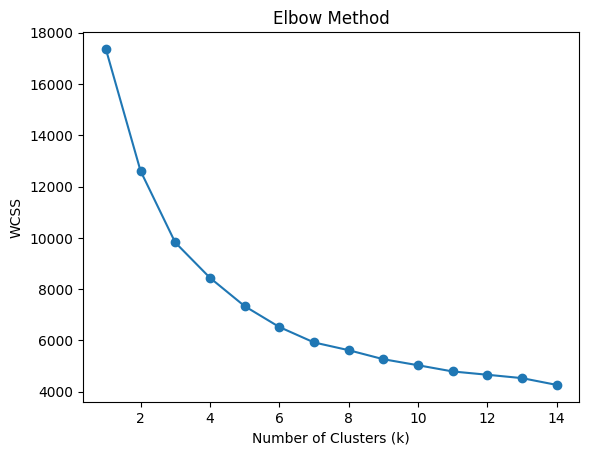

In [18]:
wcss(X_scaled)

In [19]:
def silhouette(X_scaled):
    silhouette_scores = []
    for k in range(2, 11):  # Start from k=2 (k=1 gives score=0)
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)

    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Method")
    plt.show()

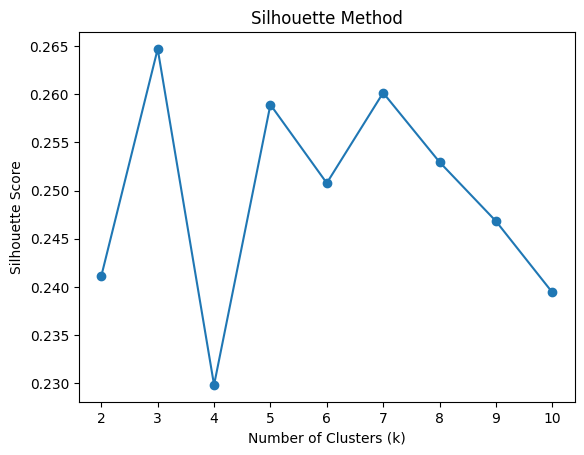

In [20]:
silhouette(X_scaled)

It seems that k=3 is the best

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [22]:
itineraries_for_cluster["cluster"] = kmeans.fit_predict(X_scaled)

In [23]:
clusters_dict={}
for n in range(0,3):
    name=f"cluster_{n}"
    clusters_dict[name]=itineraries_for_cluster[itineraries_for_cluster["cluster"]==n]

In [24]:
def cluster_characteristics(cluster):
    data={}
    cols=list(cluster.columns)
    removable_cols=["origin","destination","cluster"]
    cols_final=list(set(cols)-set(removable_cols))
    for col in cols_final:
        data[col]=cluster[col].mean()
    df=pd.DataFrame(data=data, index=[0])
    return df

In [25]:
for n in range(0,3):
    print(f"the characteristics of cluster {n} are:")
    print(cluster_characteristics(clusters_dict[f"cluster_{n}"]))

the characteristics of cluster 0 are:
   num_itineraries  avg_emissions  num_multimodal  num_rail  avg_waiting_time  \
0         2.325112     107.187459         1.08296  0.008969         41.649787   

    num_air  avg_travel_time    avg_cost  
0  1.233184       560.136749  234.464126  
the characteristics of cluster 1 are:
   num_itineraries  avg_emissions  num_multimodal  num_rail  avg_waiting_time  \
0          2.81399       22.35872        0.278219  1.863275          4.868546   

    num_air  avg_travel_time   avg_cost  
0  0.672496       333.724132  62.757834  
the characteristics of cluster 2 are:
   num_itineraries  avg_emissions  num_multimodal  num_rail  avg_waiting_time  \
0         4.281934      47.476941           1.625  0.980839         21.054353   

    num_air  avg_travel_time    avg_cost  
0  1.676095       480.543053  128.999488  


In [26]:
itineraries_for_cluster=itineraries_for_cluster.reset_index()

In [27]:
# Initialize a 4x4 matrix (rows: cluster_od, cols: cluster_do) to count mismatches
def count_matrix(itineraries_for_cluster,clusters):
    count_matrix = [[0 for _ in range(clusters)] for _ in range(clusters)]
    processed_pairs = set()
    total_pairs_miscalculated = 0

    for _, row in itineraries_for_cluster.iterrows():
        origin = row["origin"]
        destination = row["destination"]
        cluster_od = row["cluster"]
        
        # Skip if already processed
        if (origin, destination) in processed_pairs or (destination, origin) in processed_pairs:
            continue
        
        # Mark this pair (and its reverse) as processed
        processed_pairs.add((origin, destination))
        processed_pairs.add((destination, origin))
        
        # Find the reverse O-D pair
        reverse_cluster = itineraries_for_cluster[
            (itineraries_for_cluster["origin"] == destination) & 
            (itineraries_for_cluster["destination"] == origin)
        ]["cluster"]
        
        if reverse_cluster.empty:
            continue
        
        cluster_do = reverse_cluster.iloc[0]
        
        if cluster_od != cluster_do:
            print(f"Mismatch: {origin}-{destination} (Cluster {cluster_od}) vs {destination}-{origin} (Cluster {cluster_do})")
            total_pairs_miscalculated += 1
        
        # Update the count matrix (cluster_od=row, cluster_do=col)
        count_matrix[cluster_od][cluster_do] += 1

    # Convert to DataFrame
    matrix = pd.DataFrame(
        data=count_matrix,
        columns=range(clusters),
        index=range(clusters)
    )

    print(f"Total mismatched pairs: {total_pairs_miscalculated}")
    print("Cluster mismatch matrix:")
    print(matrix)
    return matrix

In [28]:
matrix=count_matrix(itineraries_for_cluster,clusters=3)

Mismatch: ES111-ES614 (Cluster 0) vs ES614-ES111 (Cluster 2)
Mismatch: ES112-ES413 (Cluster 1) vs ES413-ES112 (Cluster 2)
Mismatch: ES113-ES114 (Cluster 1) vs ES114-ES113 (Cluster 2)
Mismatch: ES114-ES242 (Cluster 0) vs ES242-ES114 (Cluster 2)
Mismatch: ES114-ES418 (Cluster 1) vs ES418-ES114 (Cluster 2)
Mismatch: ES114-ES419 (Cluster 1) vs ES419-ES114 (Cluster 2)
Mismatch: ES120-ES421 (Cluster 1) vs ES421-ES120 (Cluster 2)
Mismatch: ES120-ES532 (Cluster 0) vs ES532-ES120 (Cluster 2)
Mismatch: ES130-ES211 (Cluster 2) vs ES211-ES130 (Cluster 1)
Mismatch: ES130-ES412 (Cluster 2) vs ES412-ES130 (Cluster 1)
Mismatch: ES130-ES413 (Cluster 1) vs ES413-ES130 (Cluster 2)
Mismatch: ES130-ES414 (Cluster 2) vs ES414-ES130 (Cluster 1)
Mismatch: ES130-ES415 (Cluster 1) vs ES415-ES130 (Cluster 2)
Mismatch: ES130-ES416 (Cluster 1) vs ES416-ES130 (Cluster 2)
Mismatch: ES130-ES418 (Cluster 1) vs ES418-ES130 (Cluster 2)
Mismatch: ES130-ES421 (Cluster 2) vs ES421-ES130 (Cluster 1)
Mismatch: ES211-ES220 (C

In [29]:
# Plot the heatmap
def plot_heatmap(matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        matrix,
        annot=True,       # Show numbers in cells
        fmt="d",          # Format as integers
        cmap="YlOrRd",    # Color scheme (Yellow-Orange-Red)
        linewidths=0.5,   # Add grid lines
        linecolor="grey", # Grid line color
        cbar=True,        # Show color bar
        square=True,      # Force square cells
    )

    # Customize labels
    plt.title("Cluster Mismatch Heatmap (OD vs DO Pairs)", fontsize=14)
    plt.xlabel("Destination Cluster (DO)", fontsize=12)
    plt.ylabel("Origin Cluster (OD)", fontsize=12)

    plt.show()

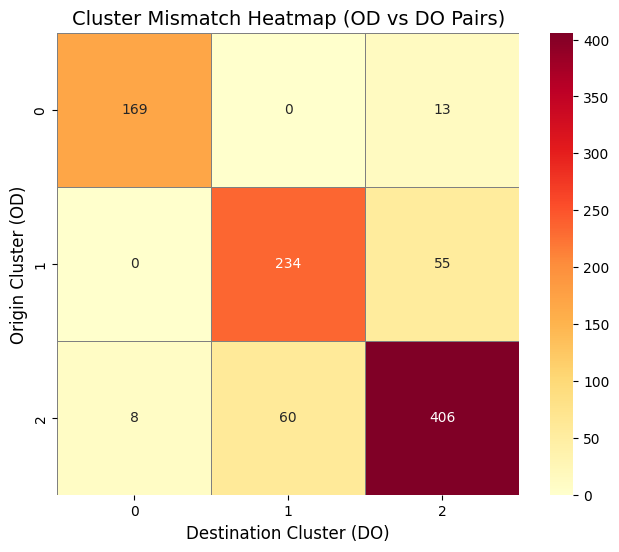

In [30]:
plot_heatmap(matrix)

# 3. Cluster without removing anything

In [31]:
itineraries=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\v=0.13\processed_cs10.pp00.so00_c1\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")

In [32]:
itineraries_for_cluster=format_itineraries(itineraries)

In [33]:
#itineraries_for_cluster=itineraries_for_cluster.drop(["avg_nservice"],axis=1)

In [34]:
itineraries_for_cluster=itineraries_for_cluster.set_index(["origin","destination"])

In [35]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(itineraries_for_cluster)

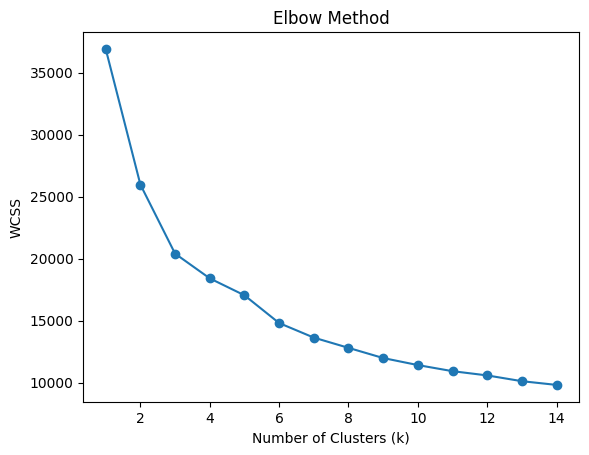

In [36]:
wcss(X_scaled)

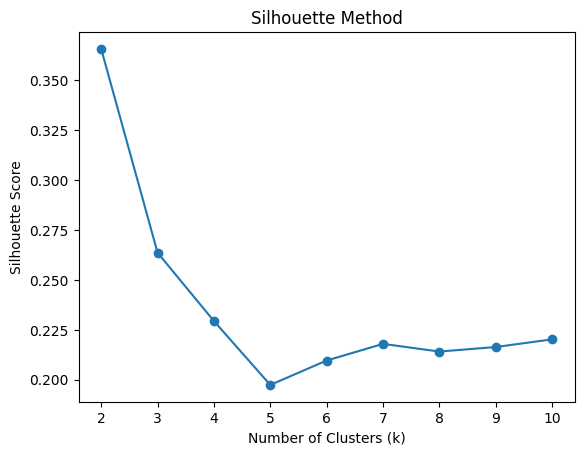

In [37]:
silhouette(X_scaled)

There is no strong candidate for cluster 

# 4 Clusters removing avg_nservices

In [38]:
itineraries=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\v=0.13\processed_cs10.pp00.so00_c1\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")
itineraries_for_cluster=format_itineraries(itineraries)
itineraries_for_cluster=itineraries_for_cluster.drop(["avg_nservice"],axis=1)

In [39]:
itineraries_for_cluster=itineraries_for_cluster.set_index(["origin","destination"])

In [40]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(itineraries_for_cluster)

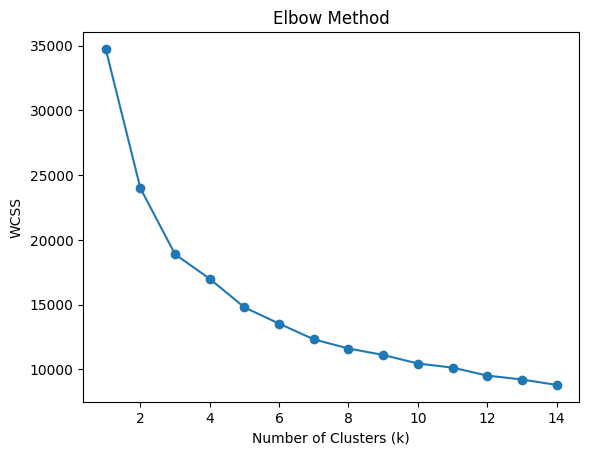

In [41]:
wcss(X_scaled)

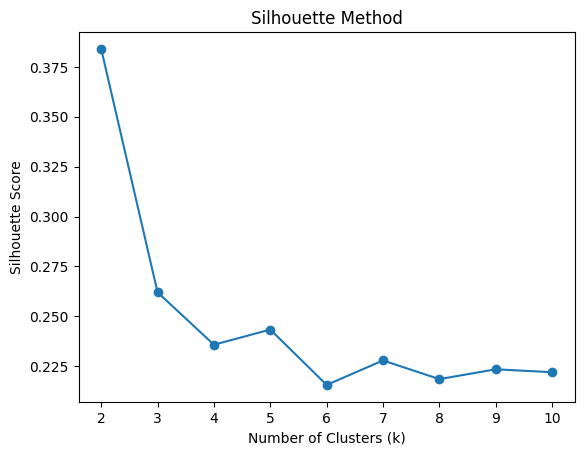

In [42]:
silhouette(X_scaled)

No Strong candidate either, perhaps 5?

# 5 Cluster removing max and min quantities

In [43]:
itineraries=pd.read_csv(r"G:\Unidades compartidas\04_PROYECTOS I+D+i\2023 MultiModX\iii) Project\WP3 Scenario definition\Case study input data\Spain\CS10\v=0.13\processed_cs10.pp00.so00_c1\paths_itineraries\possible_itineraries_clustered_pareto_0.csv")
itineraries_for_cluster=format_itineraries(itineraries)

In [44]:
itineraries_for_cluster=itineraries_for_cluster.set_index(["origin","destination"])

In [45]:
itineraries_for_cluster=itineraries_for_cluster.drop(["max_travel_time","max_cost","max_emissions","min_travel_time","min_cost","min_emissions","min_waiting_time","max_waiting_time"],axis=1)

In [46]:
scaler=StandardScaler()
X_scaled=scaler.fit_transform(itineraries_for_cluster)

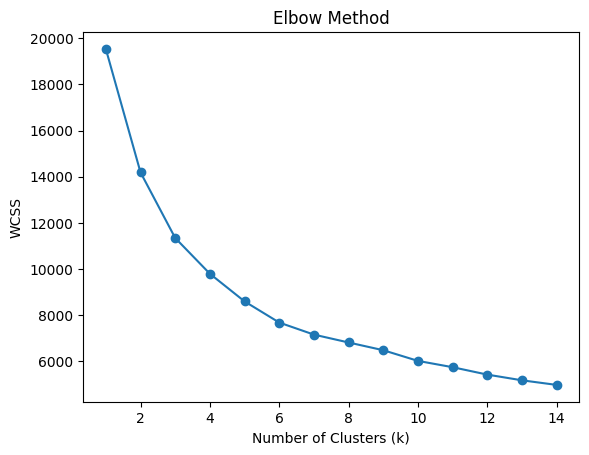

In [47]:
wcss(X_scaled)

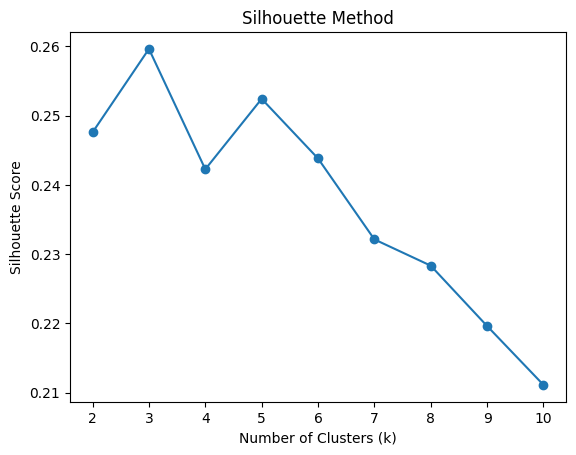

In [48]:
silhouette(X_scaled)

Again, 3 seems to be the max number of clusters

In [49]:
kmeans = KMeans(n_clusters=3, random_state=42)
itineraries_for_cluster["cluster"] = kmeans.fit_predict(X_scaled)

In [50]:
clusters_dict={}
for n in range(0,3):
    name=f"cluster_{n}"
    clusters_dict[name]=itineraries_for_cluster[itineraries_for_cluster["cluster"]==n]

In [51]:
for n in range(0,3):
    print(f"the characteristics of cluster {n} are:")
    print(cluster_characteristics(clusters_dict[f"cluster_{n}"]))

the characteristics of cluster 0 are:
   num_itineraries  avg_emissions  num_multimodal  avg_nservice  num_rail  \
0         2.342529      108.31278        1.094253      1.660115  0.011494   

   avg_waiting_time   num_air  avg_travel_time    avg_cost  
0         42.565759  1.236782       562.250689  236.439753  
the characteristics of cluster 1 are:
   num_itineraries  avg_emissions  num_multimodal  avg_nservice  num_rail  \
0         2.978297      22.081971        0.217028      1.189218  1.976628   

   avg_waiting_time   num_air  avg_travel_time   avg_cost  
0          3.485429  0.784641       328.360897  60.906322  
the characteristics of cluster 2 are:
   num_itineraries  avg_emissions  num_multimodal  avg_nservice  num_rail  \
0         4.131047      47.107133        1.612137      1.580384  0.934037   

   avg_waiting_time   num_air  avg_travel_time    avg_cost  
0         21.204762  1.584872       479.455961  128.491589  


In [52]:
itineraries_for_cluster=itineraries_for_cluster.reset_index()

In [53]:
matrix=count_matrix(itineraries_for_cluster,clusters=3)

Mismatch: ES111-ES419 (Cluster 1) vs ES419-ES111 (Cluster 2)
Mismatch: ES111-ES614 (Cluster 0) vs ES614-ES111 (Cluster 2)
Mismatch: ES112-ES413 (Cluster 1) vs ES413-ES112 (Cluster 2)
Mismatch: ES113-ES114 (Cluster 1) vs ES114-ES113 (Cluster 2)
Mismatch: ES114-ES242 (Cluster 0) vs ES242-ES114 (Cluster 2)
Mismatch: ES114-ES418 (Cluster 1) vs ES418-ES114 (Cluster 2)
Mismatch: ES120-ES421 (Cluster 1) vs ES421-ES120 (Cluster 2)
Mismatch: ES120-ES532 (Cluster 0) vs ES532-ES120 (Cluster 2)
Mismatch: ES130-ES413 (Cluster 1) vs ES413-ES130 (Cluster 2)
Mismatch: ES130-ES414 (Cluster 2) vs ES414-ES130 (Cluster 1)
Mismatch: ES130-ES415 (Cluster 1) vs ES415-ES130 (Cluster 2)
Mismatch: ES130-ES416 (Cluster 1) vs ES416-ES130 (Cluster 2)
Mismatch: ES130-ES418 (Cluster 1) vs ES418-ES130 (Cluster 2)
Mismatch: ES130-ES421 (Cluster 2) vs ES421-ES130 (Cluster 1)
Mismatch: ES130-ES533 (Cluster 0) vs ES533-ES130 (Cluster 2)
Mismatch: ES211-ES243 (Cluster 1) vs ES243-ES211 (Cluster 2)
Mismatch: ES211-ES411 (C

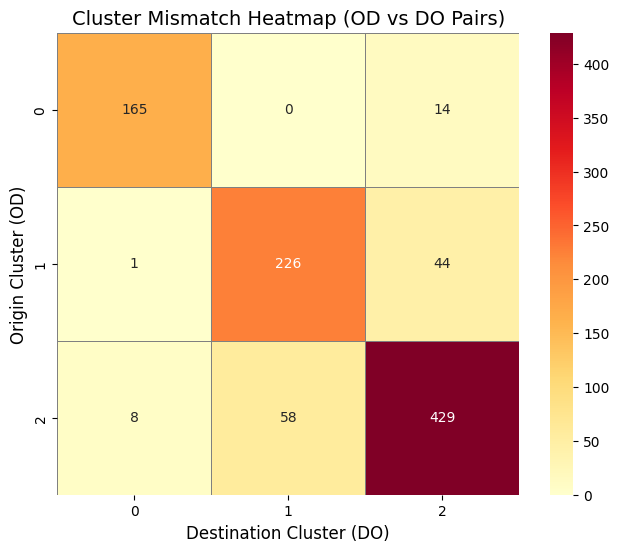

In [54]:
plot_heatmap(matrix)

In [58]:
clusters_dict["cluster_0"]=clusters_dict["cluster_0"].reset_index()
clusters_dict["cluster_1"]=clusters_dict["cluster_1"].reset_index()
clusters_dict["cluster_2"]=clusters_dict["cluster_2"].reset_index()

In [63]:
clusters_dict["cluster_0"][clusters_dict["cluster_0"]["origin"].str.startswith("ES70")]

,index,origin,destination,num_air,num_multimodal,num_rail,num_itineraries,avg_travel_time,avg_cost,avg_emissions,avg_waiting_time,avg_nservice,cluster
250,250,ES704,ES111,1,2,0,3,533.0,243.35,110.923333,23.333333,1.666667,0
251,251,ES704,ES114,1,2,0,3,549.0,240.023333,110.006667,23.333333,1.666667,0
252,252,ES704,ES130,3,1,0,4,569.125,306.29,136.64,77.625,2.0,0
253,253,ES704,ES220,2,2,0,4,586.625,281.2175,128.8,59.875,2.0,0
254,254,ES704,ES243,0,2,0,2,611.875,244.045,101.525,89.75,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,430,ES709,ES615,2,1,0,3,523.04,217.623333,97.776667,4.706667,1.333333,0
431,431,ES709,ES616,3,1,0,4,568.55,211.95,100.205,7.5,1.25,0
432,432,ES709,ES617,1,1,0,2,431.93,204.18,91.23,5.715,1.5,0
433,433,ES709,ES618,2,1,0,3,425.03,217.276667,97.8,5.243333,1.333333,0


In [65]:
clusters_dict["cluster_1"][clusters_dict["cluster_1"]["origin"].str.startswith("ES70")]

,origin,destination,num_air,num_multimodal,num_rail,num_itineraries,avg_travel_time,avg_cost,avg_emissions,avg_waiting_time,avg_nservice,cluster
587,ES703,ES705,1,0,0,1,220.0,107.66,49.25,0.0,1.0,1
588,ES704,ES709,1,0,0,1,193.0,107.04,48.44,0.0,1.0,1
589,ES705,ES703,1,0,0,1,221.75,107.66,49.25,0.0,1.0,1
590,ES705,ES707,1,0,0,1,225.0,107.35,49.03,0.0,1.0,1
591,ES705,ES709,2,0,0,2,233.075,82.295,42.57,0.0,1.0,1
592,ES707,ES705,1,0,0,1,223.0,107.35,46.31,0.0,1.0,1
593,ES707,ES708,1,0,0,1,229.0,128.41,65.91,0.0,1.0,1
594,ES708,ES707,1,0,0,1,244.0,128.41,65.91,0.0,1.0,1
595,ES708,ES709,1,0,0,1,214.0,111.37,51.58,0.0,1.0,1
596,ES709,ES704,1,0,0,1,253.0,107.04,48.44,0.0,1.0,1


In [66]:
clusters_dict["cluster_2"][clusters_dict["cluster_2"]["origin"].str.startswith("ES70")]

,origin,destination,num_air,num_multimodal,num_rail,num_itineraries,avg_travel_time,avg_cost,avg_emissions,avg_waiting_time,avg_nservice,cluster


In [78]:
clusters_dict["cluster_2"][clusters_dict["cluster_2"]["origin"].str.startswith("ES51")].count()

origin              118
destination         118
num_air             118
num_multimodal      118
num_rail            118
num_itineraries     118
avg_travel_time     118
avg_cost            118
avg_emissions       118
avg_waiting_time    118
avg_nservice        118
cluster             118
dtype: int64

In [75]:
clusters_dict["cluster_2"]

,origin,destination,num_air,num_multimodal,num_rail,num_itineraries,avg_travel_time,avg_cost,avg_emissions,avg_waiting_time,avg_nservice,cluster
0,ES111,ES130,2,1,0,3,427.166667,145.813333,55.673333,28.333333,1.333333,2
1,ES111,ES211,2,3,1,6,531.416667,137.536667,51.336667,40.666667,1.666667,2
2,ES111,ES212,2,1,1,4,493.5,131.4325,52.6275,44.0,1.5,2
3,ES111,ES213,2,1,0,3,397.333333,144.603333,57.846667,61.833333,1.333333,2
4,ES111,ES220,2,2,1,5,476.7,134.936,51.046,10.934,1.6,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1132,ES640,ES425,1,1,0,2,429.75,145.98,70.7,9.44,1.5,2
1133,ES640,ES611,2,2,0,4,462.5,123.2475,57.955,25.75,1.5,2
1134,ES640,ES613,1,1,0,2,383.61,110.19,48.855,18.5,1.5,2
1135,ES640,ES617,1,1,0,2,303.875,107.195,47.42,14.25,1.5,2


It seems we have three main types of OD pairs

### Cluster 0: Long distance itineraries with little options
These OD pairs are characterised by a lower number of itineraries (2.34 on average) and these itineraries are the longest and most polluting ones. They are dominated by air options. For example, the itineraries between the Canary Islands and the rest of Spain are part of this group.

### Cluster 1: Mostly direct shorter itineraries
These OD pairs are characterised by an average number of itineraries, mixing air and rail and favouring rail. These itineraries are mostly direct itineraries (no connection) and are the shorter ones on average. Most itineraries coming from Madrid are of this type.

### Cluster 2: Average connecting itineraries
These OD pairs are characterised by the largest number of possible itineraries and the majority of the multimodal options and connecting options. The travel time and cost seem average. Most itineraries coming from Catalunya are of this type.